<a href="https://colab.research.google.com/github/AShipulin/usurt/blob/main/%D0%9B%D0%9F%D0%A2%D0%A1_%D0%A1%D1%80%D0%B0%D0%B2%D0%BD%D0%B5%D0%BD%D0%B8%D0%B5_ARIMA%2C_Prophet_%D0%B8_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Визуализация временного ряда с трендом
Задача: Показать исходные данные и выявленный тренд.

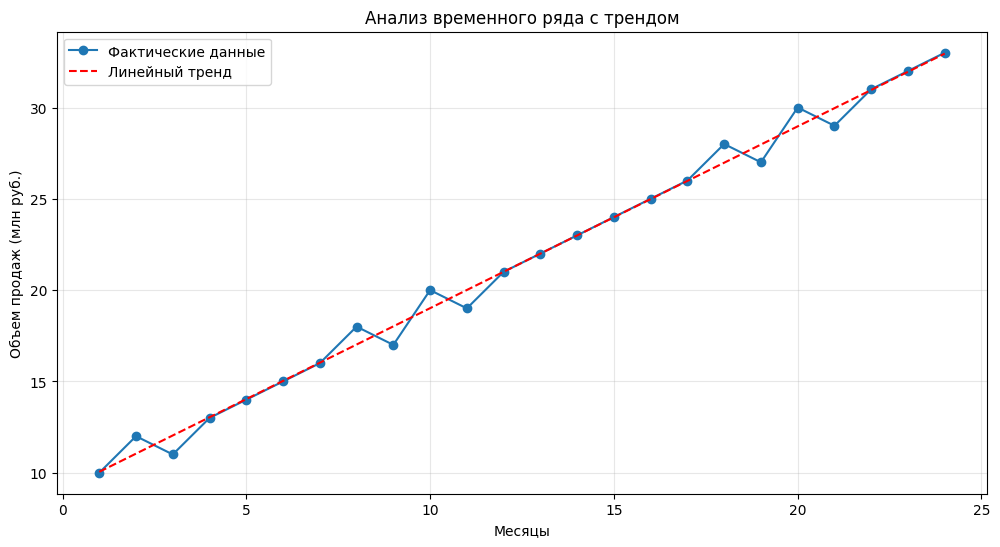

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Генерация данных (месяцы и объем продаж)
months = np.arange(1, 25)
sales = np.array([10, 12, 11, 13, 14, 15, 16, 18, 17, 20, 19, 21,
                  22, 23, 24, 25, 26, 28, 27, 30, 29, 31, 32, 33])

# Линейный тренд
slope, intercept, _, _, _ = stats.linregress(months, sales)
trend = intercept + slope * months

# График
plt.figure(figsize=(12, 6))
plt.plot(months, sales, 'o-', label='Фактические данные')
plt.plot(months, trend, 'r--', label='Линейный тренд')
plt.title('Анализ временного ряда с трендом')
plt.xlabel('Месяцы')
plt.ylabel('Объем продаж (млн руб.)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# 2. Выделение сезонности
Задача: Разложить ряд на тренд, сезонность и остатки.

<Figure size 1200x800 with 0 Axes>

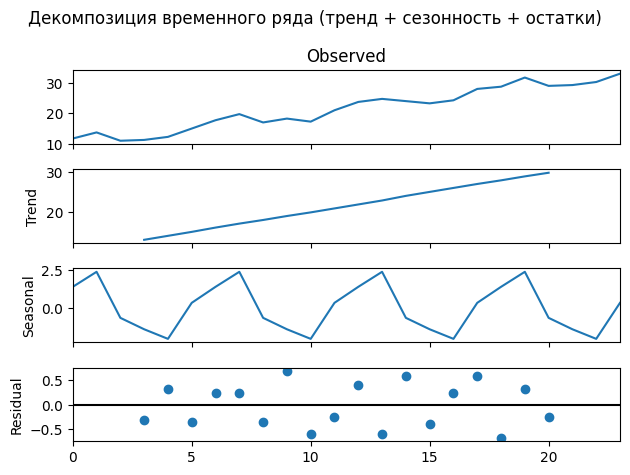

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Добавляем сезонность (например, квартальные колебания)
np.random.seed(42)
seasonal = 2 * np.sin(2 * np.pi * months / 6)
sales_with_season = sales + seasonal

# Декомпозиция
result = seasonal_decompose(sales_with_season, model='additive', period=6)

# Визуализация
plt.figure(figsize=(12, 8))
result.plot()
plt.suptitle('Декомпозиция временного ряда (тренд + сезонность + остатки)')
plt.tight_layout()
plt.show()

# 3. Прогнозирование с помощью скользящего среднего
Задача: Сгладить ряд и предсказать будущие значения.

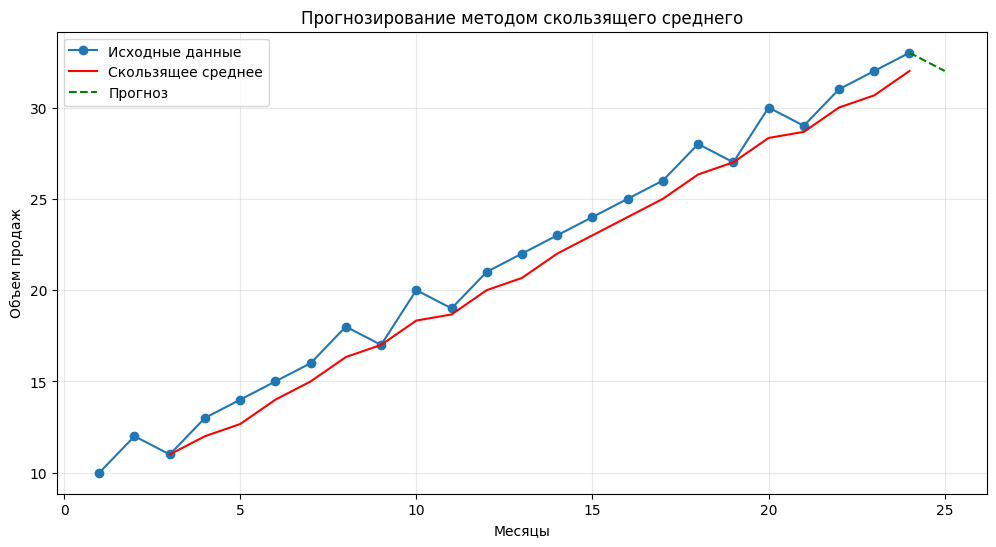

In [9]:
# Скользящее среднее (окно = 3 месяца)
window_size = 3
moving_avg = np.convolve(sales, np.ones(window_size)/window_size, mode='valid')

# Прогноз на 1 шаг вперед
last_avg = moving_avg[-1]
forecast = np.append(moving_avg, last_avg)

# График
plt.figure(figsize=(12, 6))
plt.plot(months, sales, 'o-', label='Исходные данные')
plt.plot(months[window_size-1:], moving_avg, 'r-', label='Скользящее среднее')
plt.plot([months[-1], months[-1]+1], [sales[-1], forecast[-1]], 'g--', label='Прогноз')
plt.title('Прогнозирование методом скользящего среднего')
plt.xlabel('Месяцы')
plt.ylabel('Объем продаж')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# 4. Автокорреляция (ACF) и частичная автокорреляция (PACF)
Задача: Определить лаги для моделей ARIMA.

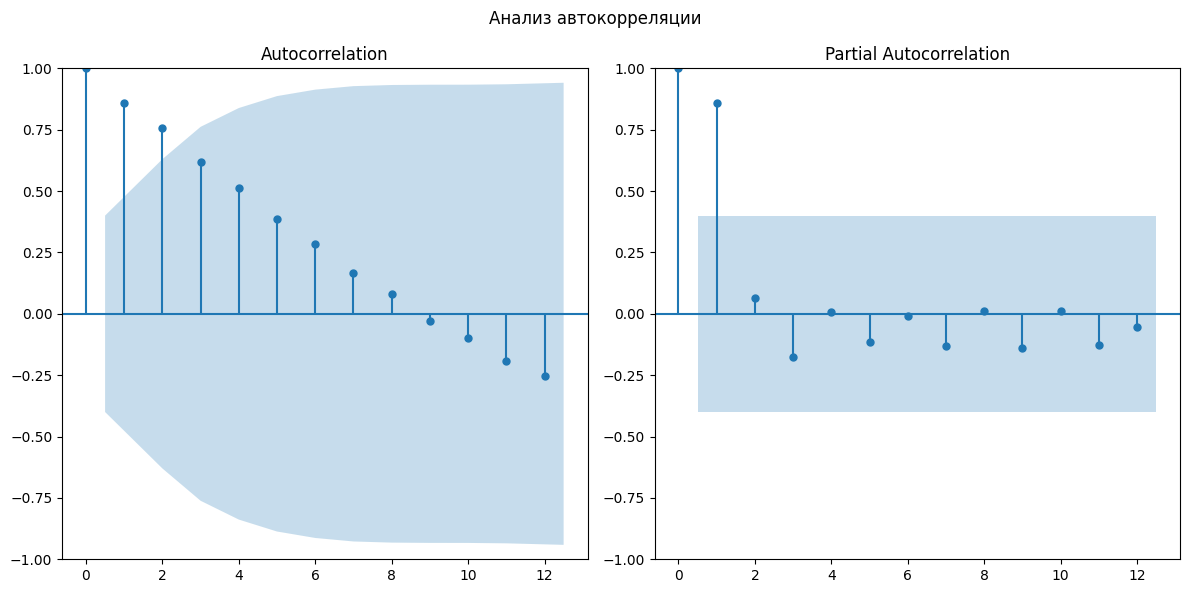

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Графики ACF и PACF
plt.figure(figsize=(12, 6))
plot_acf(sales, lags=12, ax=plt.subplot(121))
plot_pacf(sales, lags=12, ax=plt.subplot(122))
plt.suptitle('Анализ автокорреляции')
plt.tight_layout()
plt.show()

# 5. Прогнозирование ARIMA
Задача: Построить прогноз с учетом авторегрессии и скользящего среднего.

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


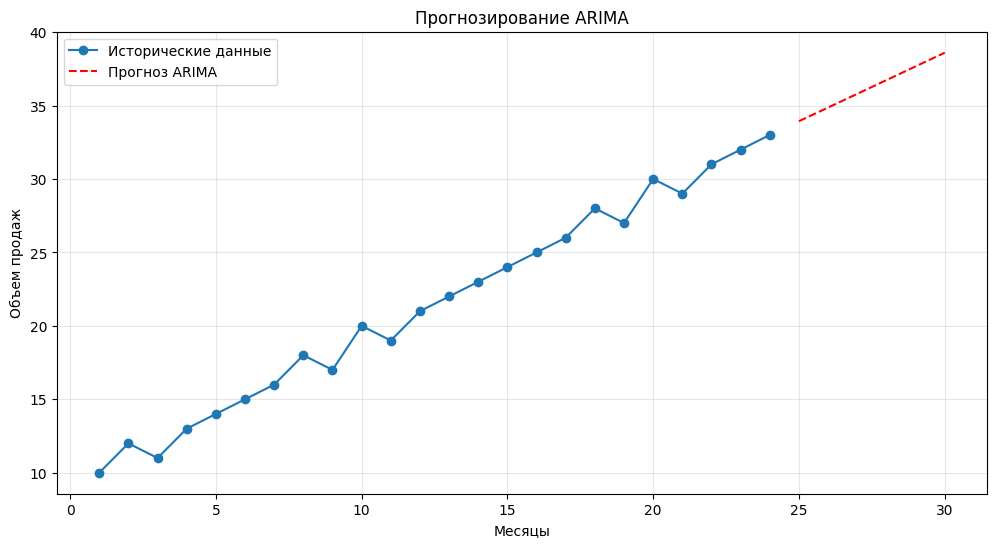

In [11]:
from statsmodels.tsa.arima.model import ARIMA

# Модель ARIMA(1,1,1)
model = ARIMA(sales, order=(1,1,1))
model_fit = model.fit()

# Прогноз на 6 месяцев
forecast = model_fit.forecast(steps=6)

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(months, sales, 'o-', label='Исторические данные')
plt.plot(np.arange(25, 31), forecast, 'r--', label='Прогноз ARIMA')
plt.title('Прогнозирование ARIMA')
plt.xlabel('Месяцы')
plt.ylabel('Объем продаж')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Сравнение ARIMA, Prophet и LSTM на примере прогнозирования грузопотоков

## 1. Подготовка данных

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Создание синтетических данных (ежемесячные грузоперевозки за 3 года)
dates = pd.date_range(start='2021-01-01', periods=36, freq='M')
cargo = np.array([50, 55, 53, 60, 65, 62, 70, 75, 72, 80, 78, 85,
                  82, 88, 90, 95, 92, 100, 105, 110, 108, 115, 120, 125,
                  122, 130, 135, 140, 138, 145, 150, 155, 153, 160, 165, 170])

# Разделение на train/test (24/12 месяцев)
train, test = cargo[:24], cargo[24:]
train_dates, test_dates = dates[:24], dates[24:]

<ipython-input-21-950ed496a12b>:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start='2021-01-01', periods=36, freq='M')


## 2. Прогнозирование с помощью ARIMA

In [22]:
from statsmodels.tsa.arima.model import ARIMA

# Модель ARIMA(1,1,1)
arima_model = ARIMA(train, order=(1,1,1))
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps=12)

# Оценка точности
arima_mae = mean_absolute_error(test, arima_forecast)

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## 3. Прогнозирование с помощью Prophet

In [23]:
from prophet import Prophet

# Подготовка данных для Prophet
df = pd.DataFrame({'ds': train_dates, 'y': train})
prophet_model = Prophet()
prophet_model.fit(df)

# Создание фрейма для прогноза
future = prophet_model.make_future_dataframe(periods=12, freq='M')
prophet_forecast = prophet_model.predict(future)['yhat'][-12:]

# Оценка точности
prophet_mae = mean_absolute_error(test, prophet_forecast)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphj7q2qhr/3y3y40b9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphj7q2qhr/hwu486yi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95070', 'data', 'file=/tmp/tmphj7q2qhr/3y3y40b9.json', 'init=/tmp/tmphj7q2qhr/hwu486yi.json', 'output', 'file=/tmp/tmphj7q2qhr/prophet_modelx2cgwf6w/prophet_model-20250422181353.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:13:53 - cmdstanpy - INFO - Chain [1] start processing
I

## 4. Прогнозирование с помощью LSTM

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Нормализация данных
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train.reshape(-1, 1))

# Подготовка временных окон
def create_dataset(data, look_back=1):
    X, y = [], []
    for i in range(len(data)-look_back):
        X.append(data[i:(i+look_back), 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

look_back = 3
X_train, y_train = create_dataset(train_scaled, look_back)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Создание модели LSTM
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(look_back, 1)),
    Dense(1)
])
lstm_model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

# Обучение модели
history = lstm_model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=1,
    verbose=0,
    validation_split=0.2
)

# Прогнозирование
lstm_forecast = []
current_batch = X_train[-1].reshape(1, look_back, 1)  # Последнее окно из тренировочных данных

for i in range(12):
    current_pred = lstm_model.predict(current_batch, verbose=0)[0]
    lstm_forecast.append(current_pred[0])

    # Обновляем батч для следующего прогноза
    current_batch = np.append(
        current_batch[:,1:,:],
        [[[current_pred[0]]]],
        axis=1
    )

# Обратное преобразование масштаба
lstm_forecast = scaler.inverse_transform(
    np.array(lstm_forecast).reshape(-1, 1)
).flatten()

# Оценка точности
lstm_mae = mean_absolute_error(test, lstm_forecast)
print(f"LSTM MAE: {lstm_mae:.2f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


LSTM MAE: 18.30


## 5. Визуализация результатов

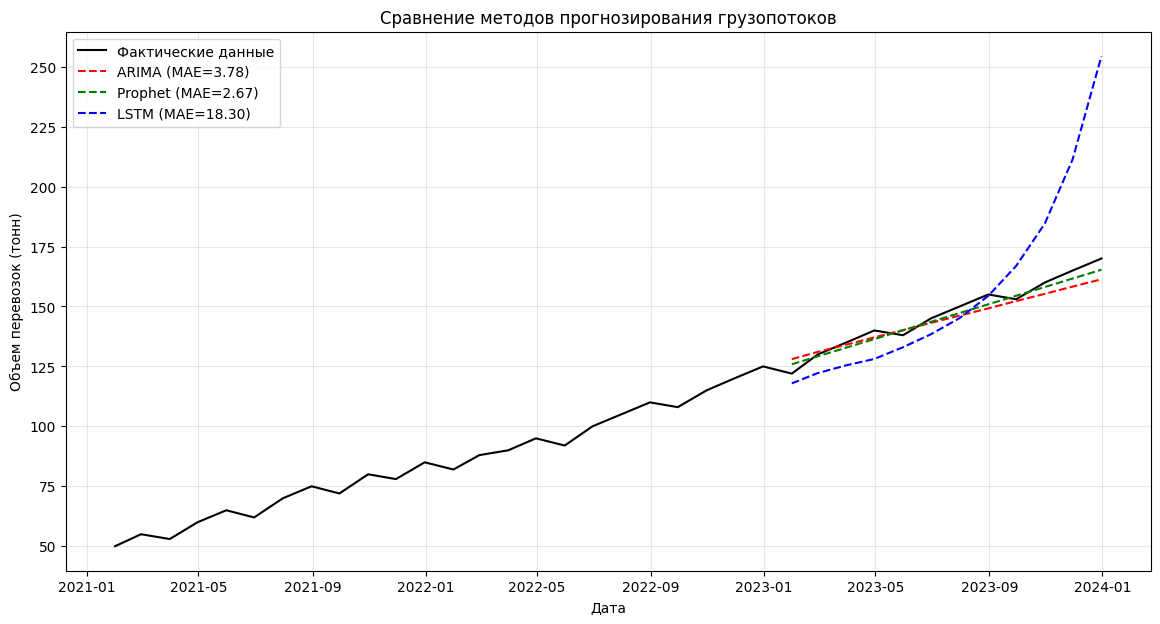

In [25]:
plt.figure(figsize=(14, 7))
plt.plot(dates, cargo, 'k-', label='Фактические данные')
plt.plot(test_dates, arima_forecast, 'r--', label=f'ARIMA (MAE={arima_mae:.2f})')
plt.plot(test_dates, prophet_forecast, 'g--', label=f'Prophet (MAE={prophet_mae:.2f})')
plt.plot(test_dates, lstm_forecast, 'b--', label=f'LSTM (MAE={lstm_mae:.2f})')
plt.title('Сравнение методов прогнозирования грузопотоков')
plt.xlabel('Дата')
plt.ylabel('Объем перевозок (тонн)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

**MAE (Mean Absolute Error)** — это метрика оценки точности прогноза, которая показывает среднюю абсолютную разницу между фактическими и прогнозируемыми значениями.  

### Формула:
$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
$$
где:
- $y_i$ — фактическое значение,
- $\hat{y}_i$ — прогнозируемое значение,
- $n$ — количество наблюдений.

---

### Особенности MAE:
1. **Интерпретируемость**:  
   MAE измеряется в тех же единицах, что и исходные данные (например, тонны груза, рубли и т.д.).  
   *Пример:* MAE = 5 тонн означает, что в среднем прогноз отклоняется на 5 тонн от реальности.

2. **Устойчивость к выбросам**:  
   В отличие от MSE (Mean Squared Error), MAE менее чувствителен к редким большим ошибкам, так как не возводит их в квадрат.

3. **Сравнение моделей**:  
   Чем меньше MAE, тем точнее модель. Например:
   - ARIMA: MAE = 4.2  
   - LSTM: MAE = 3.8 → LSTM точнее для этих данных.

---

### Пример из логистики:
Допустим, мы прогнозируем ежедневный объем грузоперевозок (в тоннах):


| День | Факт ($y_i$) | Прогноз ($\hat{y}_i$) | Ошибка $(|y_i - \hat{y}_i|$) |
|---|---|---|---------|
| 1 | 100 | 105  | 5 |
| 2 | 120 | 115 | 5  |
| 3 | 80  | 90  | 10 |

$$
\text{MAE} = \frac{5 + 5 + 10}{3} = 6.67 \text{ тонн}
$$

**Вывод:** В среднем прогноз отклоняется на 6.67 тонн.

---

### Когда использовать MAE?
- **Для интерпретируемости**: Если важно понимать среднюю величину ошибки в "физических" единицах.
- **При наличии выбросов**: Когда данные содержат аномалии (например, резкие скачки спроса).
- **Для сравнения моделей**: ARIMA vs Prophet vs LSTM.

**Ограничение:** MAE не показывает направление ошибки (завышение или занижение прогноза). Для этого используют **MBE (Mean Bias Error)**.

---

### Дополнительные метрики (для комплексной оценки):
1. **MSE (Mean Squared Error)** — усиливает влияние больших ошибок.  
2. **RMSE (Root MSE)** — возвращается к исходным единицам измерения.  
3. **MAPE (Mean Absolute Percentage Error)** — ошибка в процентах.  

**Совет:** В логистике чаще используют MAE или MAPE, так как они понятнее для бизнеса. Например:  
- *"Наша модель ошибается в среднем на 5% (MAPE)"*.